In [1]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(biomaRt))
options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/')
fold_notebook <- 'castom_cad_scz/jupyter_notebook/'
functR <- sprintf('%sFunctions_prediction_plots.R', fold_notebook)
source(functR)

color_file <- sprintf('%scolor_tissues.txt', fold_notebook)
fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/'
fold_rep <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB_other_ancestry/'
out_fold <- sprintf('%sCAD_other_ancestry/', fold_notebook)

pheno <- 'CAD_HARD'
train_fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/'
type_dat <- 'CAD_HARD-UKBB'
pval_FDR <- 0.05

# load results
color_tissues <- read.table(color_file, h=T, stringsAsFactors = F)
tscore <- fread(sprintf('%stscore_pval_%s_covCorr.txt', fold, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)
tscore_repl <- fread(sprintf('%stscore_pval_%s_covCorr.txt', fold_rep, pheno), 
                     h=T, stringsAsFactors = F, data.table = F) %>%
  rename_with(~str_replace(., "^CAD_HARD", "Indian_CAD_HARD"), starts_with("CAD_HARD"))

pathR <- fread(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold, pheno), 
               h=T, stringsAsFactors = F, sep = '\t', data.table = F)
pathR_repl <- fread(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold_rep, pheno), 
                     h=T, stringsAsFactors = F, data.table = F) %>%
  rename_with(~str_replace(., "^CAD_HARD", "Indian_CAD_HARD"), starts_with("CAD_HARD")) %>%
  rename(Indian_improvement_sign = improvement_sign, 
         Indian_mean_gene_corr = mean_gene_corr, 
         Indian_sd_gene_corr = sd_gene_corr)

pathGO <- fread(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)
pathGO_repl <- fread(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold_rep, pheno), 
                     h=T, stringsAsFactors = F, data.table = F) %>%
  rename_with(~str_replace(., "^CAD_HARD", "Indian_CAD_HARD"), starts_with("CAD_HARD")) %>%
  rename(Indian_improvement_sign = improvement_sign, 
         Indian_mean_gene_corr = mean_gene_corr, 
         Indian_sd_gene_corr = sd_gene_corr)

pathWiki <- fread(sprintf('%spath_WikiPath2019Human_pval_%s_covCorr_filt.txt', fold, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)
pathWiki_repl <- fread(sprintf('%spath_WikiPath2019Human_pval_%s_covCorr_filt.txt', fold_rep, pheno), 
                     h=T, stringsAsFactors = F, data.table = F) %>%
  rename_with(~str_replace(., "^CAD_HARD", "Indian_CAD_HARD"), starts_with("CAD_HARD")) %>%
  rename(Indian_improvement_sign = improvement_sign, 
         Indian_mean_gene_corr = mean_gene_corr, 
         Indian_sd_gene_corr = sd_gene_corr)

tissues <- unique(tscore$tissue)
train_fold <- paste0(train_fold, tissues, '/200kb/CAD_GWAS_bin5e-2/')



In [2]:
# order of features is the same
identical(tscore_repl$ensembl_gene_id, tscore$ensembl_gene_id)
identical(pathR_repl$path, pathR$path)
identical(pathGO_repl$path, pathGO$path)
identical(pathWiki_repl$path, pathWiki$path)

tscore_complete <- dplyr::full_join(tscore, tscore_repl) %>%
    dplyr::mutate(replicated = sign(CAD_HARD_z_t * Indian_CAD_HARD_z_t) == 1) %>%
    dplyr::filter(CAD_HARD_BHcorr <= 0.05)

pathR_complete <- dplyr::full_join(pathR, pathR_repl) %>%
    dplyr::mutate(replicated = sign(CAD_HARD_z_t * Indian_CAD_HARD_z_t) == 1) %>%
    dplyr::filter(CAD_HARD_BHcorr <= 0.05)

pathGO_complete <- dplyr::full_join(pathGO, pathGO_repl) %>%
    dplyr::mutate(replicated = sign(CAD_HARD_z_t * Indian_CAD_HARD_z_t) == 1) %>%
    dplyr::filter(CAD_HARD_BHcorr <= 0.05)

pathWiki_complete <- dplyr::full_join(pathWiki, pathWiki_repl) %>%
    dplyr::mutate(replicated = sign(CAD_HARD_z_t * Indian_CAD_HARD_z_t) == 1) %>%
    dplyr::filter(CAD_HARD_BHcorr <= 0.05)

common_i <- intersect(colnames(pathR_complete), colnames(pathGO_complete))
common_i <- intersect(common_i, colnames(pathWiki_complete))
tmp1 <- pathR_complete[, common_i]
tmp2 <- pathGO_complete[, common_i]
tmp3 <- pathWiki_complete[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tmp3$type_path <- 'WikiHuman'
tot_path_complete <- rbind(tmp1, tmp2, tmp3)


[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

Joining, by = c("ensembl_gene_id", "external_gene_name", "dev_geno", "test_dev_geno", "tissue")

Joining, by = c("path", "ngenes_tscore", "ngenes_path", "mean_dev_geno", "sd_dev_geno", "mean_test_dev_geno", "sd_test_dev_geno", "genes_path", "tissue")

Joining, by = c("path_id", "path", "path_ont", "ngenes_tscore", "ngenes_path", "mean_dev_geno", "sd_dev_geno", "mean_test_dev_geno", "sd_test_dev_geno", "genes_path", "tissue")

Joining, by = c("path", "ngenes_tscore", "ngenes_path", "mean_dev_geno", "sd_dev_geno", "mean_test_dev_geno", "sd_test_dev_geno", "genes_path", "tissue")



In [3]:
### plot ###
create_df_repr <- function(df_complete, pval_nom = 0.05, type_name, var_name){
    
    pval_var_name <- paste0(var_name, "_pval")
    print(pval_var_name)
    tissue_spec <- df_complete %>% 
    dplyr::group_by(tissue) %>% 
    dplyr::summarise(n = length(replicated),
              n_sign = sum(replicated),
              frac_sign = sum(replicated)/length(replicated), 
              binomial_pval = binom.test(sum(replicated), length(replicated), p = 0.5, alternative = c("greater"))$p.value,
              frac_notsign = sum(!replicated)/length(replicated),
              frac_sign_nom = sum(replicated & (get(pval_var_name) <= pval_nom))/length(replicated),
              frac_sign_notnom = sum(replicated & (get(pval_var_name) > pval_nom))/length(replicated))

    df_summary <- df_complete %>% 
        dplyr::summarise(tissue = 'All tissues', n = length(replicated),
              n_sign = sum(replicated),
              frac_sign = sum(replicated)/length(replicated), 
              binomial_pval = binom.test(sum(replicated), length(replicated), p = 0.5, alternative = c("greater"))$p.value,
              frac_notsign = sum(!replicated)/length(replicated),
              frac_sign_nom = sum(replicated & (get(pval_var_name) <= pval_nom))/length(replicated),
              frac_sign_notnom = sum(replicated & (get(pval_var_name) > pval_nom))/length(replicated)) %>% 
        dplyr::bind_rows(tissue_spec) %>% 
        dplyr::mutate(type = type_name)
    
     df_pval <- df_summary %>% 
        dplyr::select(tissue, binomial_pval, frac_sign, type) %>% 
        dplyr::mutate(pos = frac_sign + 0.05) %>% 
        dplyr::mutate(sign_symbol = case_when(binomial_pval <=0.05 & binomial_pval>0.01 ~ "*", 
                                       binomial_pval <=0.01 & binomial_pval>0.001 ~ "**", 
                                       binomial_pval <=0.001 & binomial_pval>0.0001 ~ "***",
                                       binomial_pval <=0.0001 ~ "****", 
                                       TRUE ~ ""))
    
    tmp1 <- df_summary %>% 
        dplyr::select(tissue, n,  n_sign, frac_sign, frac_sign_notnom, type) %>% 
        dplyr::mutate(type_rep = sprintf('replication P > %.2f', pval_nom)) %>% 
        dplyr::rename( frac = frac_sign_notnom)
    tmp2 <- df_summary %>% 
        dplyr::select(tissue, n , n_sign, frac_sign, frac_sign_nom, type) %>% 
        dplyr::mutate(type_rep = sprintf('replication P < %.2f', pval_nom)) %>% 
        dplyr::rename(frac = frac_sign_nom)
    
    output <- bind_rows(tmp1, tmp2)
    output$type_rep <- factor(output$type_rep, 
                              levels = c(sprintf('replication P > %.2f', pval_nom),
                                         sprintf('replication P < %.2f', pval_nom)))
    output$tissue <- factor(output$tissue, levels = rev(df_summary$tissue))
    df_pval$tissue <- factor(df_pval$tissue, levels = rev(df_summary$tissue))

    return(list(pval = df_pval, frac = output))

}


[1] "Indian_CAD_HARD_pval"
[1] "Indian_CAD_HARD_pval"


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


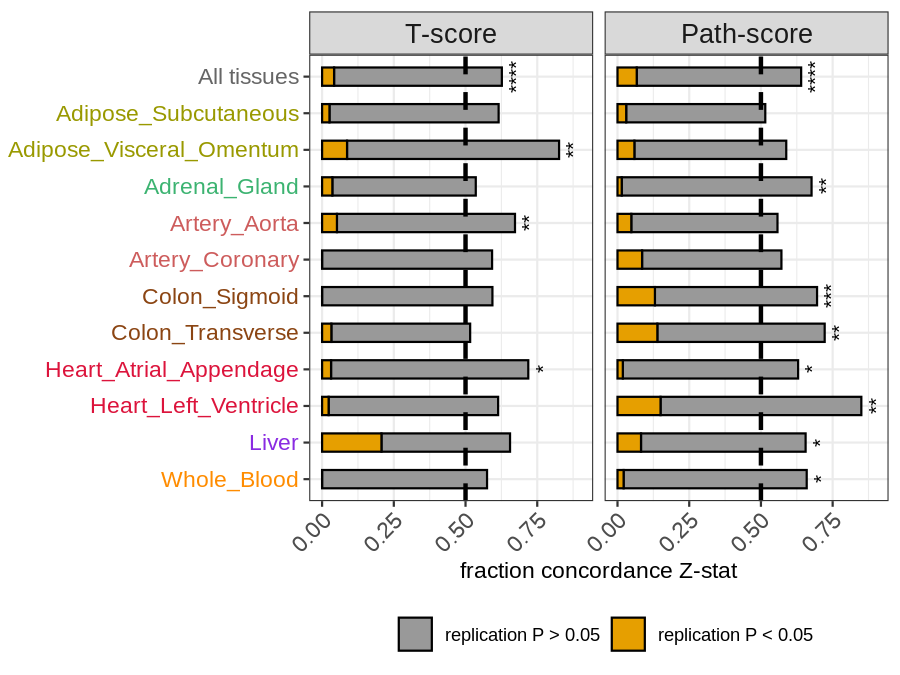

In [4]:
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 150)

df_t <- create_df_repr(tscore_complete, type_name = 'T-score', var_name = 'Indian_CAD_HARD')
df_p <- create_df_repr(df_complete = tot_path_complete, type_name = 'Path-score', var_name = 'Indian_CAD_HARD')

df_frac <- rbind(df_t$frac, df_p$frac) 
df_pval <- rbind(df_t$pval, df_p$pval) 
df_frac$type <- factor(df_frac$type, levels = c('T-score','Path-score'))
df_pval$type <- factor(df_pval$type, levels = c('T-score','Path-score'))

color_tissues_CAD <- color_tissues$color[match(tissues, color_tissues$tissues)]
color_tissues_CAD <- c('#666666', color_tissues_CAD)


pl_bar <- ggplot(data = df_frac, mapping = aes(x = tissue, y = frac, fill = type_rep))+
  geom_bar(stat = 'identity', color = 'black', alpha = 1, width = 0.5)+
  geom_hline(yintercept = 0.5, linetype = 'dashed', size = 1)+
  geom_text(data = df_pval, aes(x = tissue, y = pos, label = sign_symbol), size = 3.5, 
            angle = 90, inherit.aes = FALSE)+
  facet_wrap(.~type, nrow = 1)+
  theme_bw()+
  theme(legend.position = 'bottom', legend.title = element_blank(), 
        axis.text.y = element_text(colour = rev(color_tissues_CAD), size = 11), 
        axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
        axis.title.y = element_blank(), strip.text.x = element_text(size = 13))+
  scale_fill_manual(values = c('#999999','#E69F00'))+
  ylab('fraction concordance Z-stat')+
  coord_flip()

pl_bar 

write.table(file  = sprintf('%s/signConcordance_discoveryUKBB_replicationUKBBIndian.txt', out_fold), 
            x = df_frac, 
            quote = F, sep = "\t", 
            col.names = T, 
            row.names = F)
ggsave(plot = pl_bar, 
       filename = sprintf('%s/signConcordance_discoveryUKBB_replicationUKBBIndian.pdf', out_fold), width = 6, height = 4.5)



Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


tissue,n,n_sign,frac_sign,frac,type,type_rep,cohort
<fct>,<int>,<int>,<dbl>,<dbl>,<fct>,<fct>,<chr>
All tissues,383,240,0.6266319,0.58485640,T-score,replication P > 0.05,Indian UKBB
All tissues,383,240,0.6266319,0.04177546,T-score,replication P < 0.05,Indian UKBB
All tissues,567,363,0.6402116,0.57319224,Path-score,replication P > 0.05,Indian UKBB
All tissues,567,363,0.6402116,0.06701940,Path-score,replication P < 0.05,Indian UKBB
All tissues,383,313,0.8172324,0.31592689,T-score,replication P > 0.05,CARDIoGRAM
All tissues,383,313,0.8172324,0.50130548,T-score,replication P < 0.05,CARDIoGRAM
All tissues,567,486,0.8571429,0.49382716,Path-score,replication P > 0.05,CARDIoGRAM
All tissues,567,486,0.8571429,0.36331570,Path-score,replication P < 0.05,CARDIoGRAM


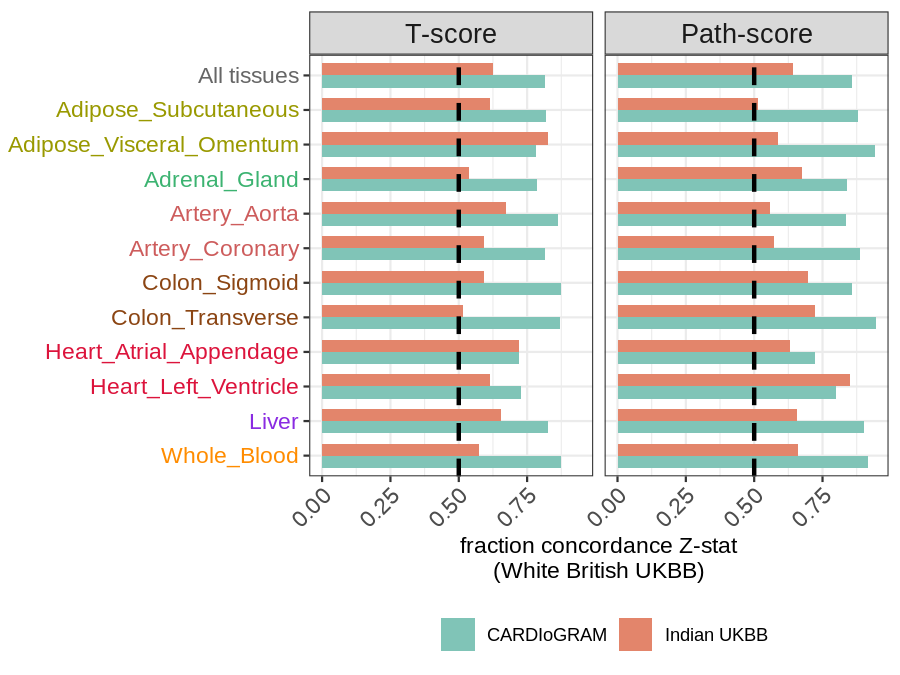

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 150)

# compare with replication in cardiogram
df_frac_CARDIOGRAM <- read.table("priler_project/Figure_CASTom-iGEx_paper/CAD_part1/signConcordance_discoveryUKBB_replicationCardioGram.txt", 
                                 h=T, 
                                 stringsAsFactors = F, 
                                 sep = "\t")

df_frac_INDIAN <- df_frac %>% mutate(cohort = "Indian UKBB")
df_frac_CARDIOGRAM <- df_frac_CARDIOGRAM %>% mutate(cohort = "CARDIoGRAM")
df_frac_tot <- rbind(df_frac_INDIAN, df_frac_CARDIOGRAM)

pl_bar <- ggplot(data = df_frac_tot, mapping = aes(x = tissue, y = frac_sign, fill = cohort))+
  geom_bar(stat = 'identity', color = 'transparent', alpha = 1, width = 0.7, position = position_dodge())+
  geom_hline(yintercept = 0.5, linetype = 'dashed', size = 1)+
  #geom_text(data = df_pval, aes(x = tissue, y = pos, label = sign_symbol), size = 3.5, 
  #          angle = 90, inherit.aes = FALSE)+
  facet_wrap(.~type, nrow = 1)+
  theme_bw()+
  theme(legend.position = 'bottom', legend.title = element_blank(), 
        axis.text.y = element_text(colour = rev(color_tissues_CAD), size = 11), 
        axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
        axis.title.y = element_blank(), strip.text.x = element_text(size = 13))+
  ylab('fraction concordance Z-stat\n(White British UKBB)')+
  scale_fill_manual(values = c('#80C4B7', '#E3856B'))+
  coord_flip()

pl_bar 

df_frac_tot %>% filter(tissue == "All tissues")

ggsave(plot = pl_bar, 
       filename = sprintf('%s/signConcordance_discoveryUKBB_replicationUKBBIndian_and_replicationCardiogram.pdf', out_fold), width = 6, height = 4.5)




Warning message:
“Removed 5 rows containing missing values (geom_segment).”
Warning message:
“Removed 5 rows containing missing values (geom_segment).”


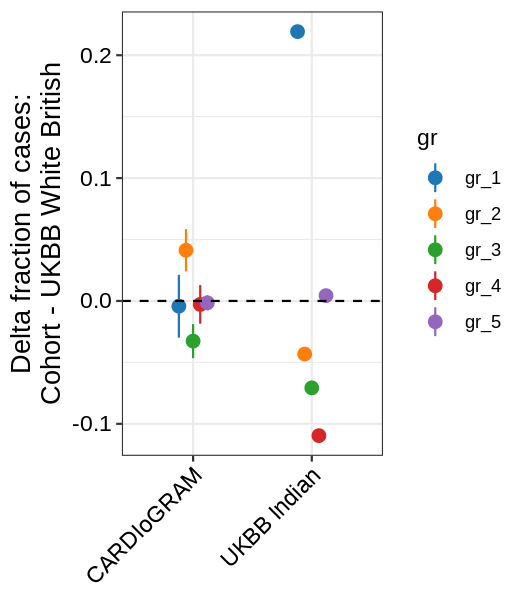

In [8]:
options(repr.plot.width = 3.5, repr.plot.height = 4, repr.plot.res = 150)

# replication of clustering prediction in Liver
fold_cardiogram <- "CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/CAD_HARD_clustering/update_corrPCs/"
fold_indian <- "CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB_other_ancestry/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/"

perc_cardiogram_repl <- read.table(sprintf("%stscore_corrPCs_zscaled_clusterCases_percentageGropus_prediction_modelUKBB.txt",
                                fold_cardiogram), h=T, stringsAsFactors = F, sep = "\t")

perc_indian_repl <- read.table(sprintf("%stscore_corrPCs_zscaled_clusterCases_percentageGropus_prediction_modelUKBB.txt",
                                fold_indian), h=T, stringsAsFactors = F, sep = "\t")

perc_model <- perc_cardiogram_repl %>% 
    filter(type == "model") %>% 
    dplyr::select(-n) %>%
    dplyr::mutate(sd_percentage = NA) %>%
    dplyr::rename(mean_percentage = percentage) %>%
    dplyr::relocate(gr, .before = "dataset")

perc_indian_repl <- perc_indian_repl %>% 
    filter(type != "model") %>% 
    dplyr::select(-n) %>%
    dplyr::mutate(sd_percentage = NA) %>%
    dplyr::rename(mean_percentage = percentage) %>%
    dplyr::relocate(gr, .before = "dataset") %>%
    dplyr::mutate(diff_perc = mean_percentage - perc_model$mean_percentage)

perc_cardiogram_repl <- perc_cardiogram_repl %>% 
    filter(type != "model") %>%
    group_by(gr) %>%
    summarise(dataset = "CARDIoGRAM", 
              type = "predict",  
              mean_percentage = mean(percentage), 
              sd_percentage = sd(percentage)) %>%
    dplyr::mutate(diff_perc = mean_percentage - perc_model$mean_percentage)

perc_tot <- rbind(perc_cardiogram_repl, perc_indian_repl) %>%
    dplyr::mutate(dataset = case_when(dataset == "UKBB_other_ancestry" ~ "UKBB Indian", 
                                       TRUE ~ dataset))

perc_tot$gr <- factor(perc_tot$gr)
P <- length(unique(perc_tot$gr))
gr_color <- pal_d3(palette = 'category20')(P)


pl <- ggplot(perc_tot, 
             aes(x = dataset, 
                 y = diff_perc, 
                 color = gr, 
                 group = gr))+
  geom_pointrange(aes(ymin=diff_perc-sd_percentage, ymax=diff_perc+sd_percentage), 
                 size = 0.5,position = position_dodge(width = 0.3))+
  theme_bw()+ 
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  ylab('Delta fraction of cases:\nCohort - UKBB White British')+ 
  theme(legend.position = 'right', 
        axis.title.x = element_blank(), 
        axis.text = element_text(colour = "black", size = 11),
        axis.title = element_text(colour = "black", size = 13),
        axis.text.x = element_text(angle = 45, hjust = 1))+
  scale_color_manual(values = gr_color)

pl

ggsave(plot = pl, 
       filename = sprintf('%s/clLiver_diffPercentageGropus_predictionIndian_and_Cardiogram_modelUKBB.pdf', out_fold), 
       width = 3.5, height = 4)



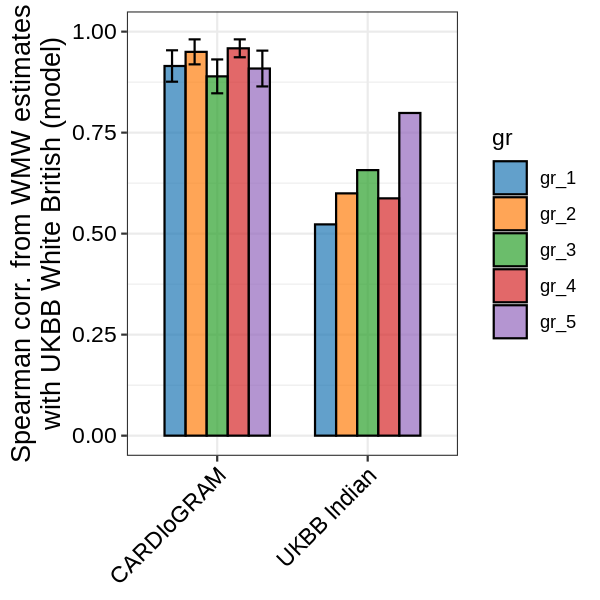

In [13]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 150)

# replication of clustering prediction in Liver
model_name <- "UKBB White British"
fold_cardiogram <- "CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/CAD_HARD_clustering/update_corrPCs/"
fold_indian <- "CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB_other_ancestry/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/"

wmwest_cardiogram_repl <- read.table(sprintf("%stscore_corrPCs_zscaled_clusterCases_correlationSpear_WMWestSign_Groups_prediction_modelUKBB.txt",
                                fold_cardiogram), h=T, stringsAsFactors = F, sep = "\t")

wmwest_indian_repl <- read.table(sprintf("%stscore_corrPCs_zscaled_clusterCases_correlationSpear_WMWestSign_Groups_prediction_modelUKBB.txt",
                                fold_indian), h=T, stringsAsFactors = F, sep = "\t")

wmwest_cardiogram_repl <- wmwest_cardiogram_repl %>% 
    group_by(gr) %>%
    summarise(dataset = "CARDIoGRAM", 
              mean_corr = mean(corr), 
              sd_corr = sd(corr))

wmwest_indian_repl <- wmwest_indian_repl %>% 
    dplyr::select(-nfeat, -pvalue) %>%
    dplyr::mutate(sd_corr = NA) %>%
    dplyr::rename(mean_corr = corr) %>%
    dplyr::relocate(gr, .before = "dataset") %>%
    dplyr::mutate(dataset = "UKBB Indian")

wmwest_tot <- rbind(wmwest_cardiogram_repl, wmwest_indian_repl)

wmwest_tot$gr <- factor(wmwest_tot$gr)
P <- length(unique(wmwest_tot$gr))
gr_color <- pal_d3(palette = 'category20')(P)

pl <- ggplot(wmwest_tot, aes(x = dataset, y = mean_corr, fill = gr, group = gr))+
    geom_bar(stat = 'identity',width = 0.7, color = 'black', alpha = 0.7, position = position_dodge())+
    geom_errorbar(aes(ymin=mean_corr -sd_corr, ymax=mean_corr+sd_corr), width=.4, position=position_dodge(.75))+
    theme_bw()+ 
    coord_cartesian(ylim = c(ifelse(min(wmwest_tot$mean_corr)<0.6, 0, 0.6),1)) +
    ylab(sprintf('Spearman corr. from WMW estimates\nwith %s (model)', model_name))+ 
    theme(legend.position = 'right', 
        axis.title.x = element_blank(), 
        axis.text = element_text(colour = "black", size = 11),
        axis.title = element_text(colour = "black", size = 13),
        axis.text.x = element_text(angle = 45, hjust = 1))+
    scale_fill_manual(values = gr_color)
pl

ggsave(plot = pl, 
       filename = sprintf('%sclLiver_correlationSpear_WMWestSign_Groups_predictionIndian_and_Cardiogram_modelUKBB.pdf', out_fold), 
       width = 4, height = 4)